In [ ]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from tqdm import tqdm

import slay
from slay.autoencoder import SpikeDataset
from slay.schemas import RunParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Hippocampus bursting example

In [2]:
data_dir = "D:/SLAY_data/mouse_hippocampus"
presence_ratio_dists = {}
spatial_mismatch_dists = {}

for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        if ("ks2" in dir_name) and ("orig" not in dir_name):
            ks_dir = os.path.join(root, dir_name)
            args = {"KS_folder": ks_dir}
            args = slay.parse_kilosort_params(args)
            schema = RunParams()
            params = schema.load(args)
            clusters, cl_labels, _, _, n_clust, times_multi, counts = (
                slay.load_ks_files(params)
            )

D:\SLAY_data\mouse_hippocampus\catgt_ANM480363_20210527_pfc320_hpc180_g0\ANM480363_20210527_pfc320_hpc180_g0_imec1\ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin
Loading files...


In [3]:
def load_channel_positions(full_path):
    channel_pos = np.load(
        os.path.join(full_path, "channel_positions.npy")
    )  # channel order

    channel_map = np.load(
        os.path.join(full_path, "channel_map.npy")
    ).flatten()  # channel order -> data order

    inverted_map = np.ones(channel_map.max() + 1, dtype=int) * -9999
    for i, ch in enumerate(channel_map):
        inverted_map[ch] = i  # ch row of data == i row of channel_pos

    channel_pos_reindex = np.ones((inverted_map.shape[0], 2)) * np.nan
    for i in range(inverted_map.shape[0]):
        if inverted_map[i] != -9999:
            channel_pos_reindex[i] = channel_pos[inverted_map[i]]

    null_inds = np.where(np.isnan(channel_pos_reindex[:, 0]))[0]
    inverted_map[null_inds] = np.zeros_like(null_inds)
    channel_pos_reindex[null_inds] = np.zeros((len(null_inds), 2))

    return channel_pos_reindex, channel_map, inverted_map, null_inds

channel_pos, channel_map, inverted_map, null_inds = load_channel_positions(ks_dir)
templates = np.load(os.path.join(ks_dir, "templates.npy"))[:, :, inverted_map].transpose(0, 2, 1)
templates[:, null_inds, :] = np.zeros((templates.shape[0], len(null_inds), templates.shape[2]))

spike_templates = np.load(os.path.join(ks_dir, "spike_templates.npy"))

for i in [3, 6]:
    template_ind = scipy.stats.mode(
                    spike_templates[np.where(clusters == i)[0]].flatten()
                )[0]
    print(template_ind)

mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))

3
6


In [151]:
spikes = {}
for i in [3, 6]:
    spikes[i] = slay.extract_spikes(_, times_multi, i, pre_samples=15, post_samples=25,max_spikes=200)

In [152]:
def find_best_channels(template):
    amplitude_threshold = 0.2

    amplitude = template.max(axis=1) - template.min(axis=1)
    best_channel = np.argmax(amplitude)
    max_amp = amplitude[best_channel]

    peak_channels = np.argsort(amplitude)[::-1]
    peak_channels = peak_channels[
        amplitude[peak_channels] > amplitude_threshold * max_amp
    ]

    return peak_channels, best_channel

In [153]:
print(find_best_channels(mean_wf[3]))
print(find_best_channels(mean_wf[6]))

best_channels = np.intersect1d(find_best_channels(mean_wf[3])[0], find_best_channels(mean_wf[6])[0])
print(best_channels)

(array([2, 4, 0, 6, 8, 7], dtype=int64), 2)
(array([ 2,  4,  0,  6,  7,  8,  9, 10], dtype=int64), 2)
[0 2 4 6 7 8]


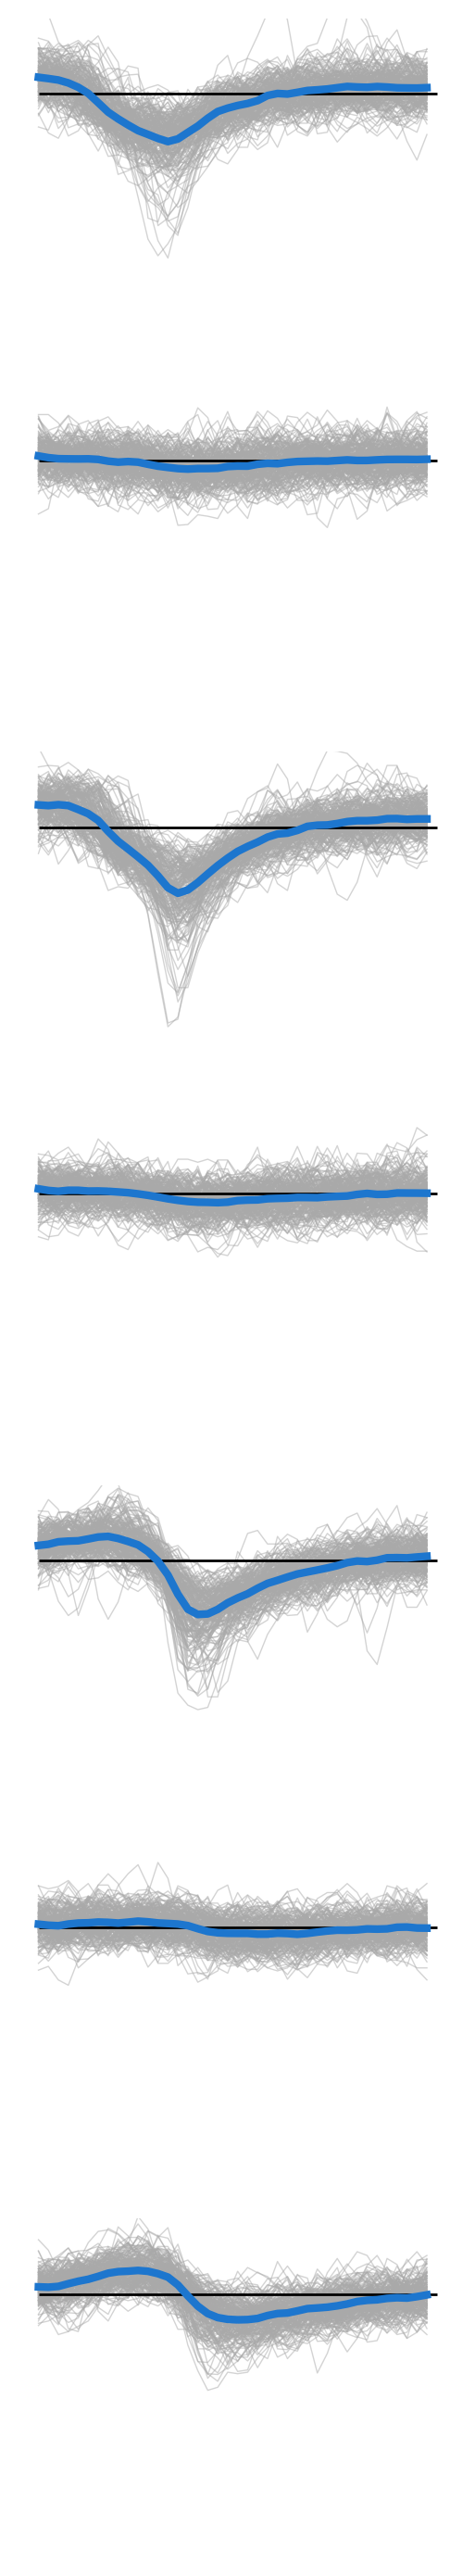

In [167]:
plt.figure(figsize=(8/3, 14))

ylim = [-350, 100]

for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(spikes[3][:,i,:].T, c='#A9A9A9',  lw=0.5, alpha=0.5
)   
    plt.hlines(0, 0, 40, color="black", lw=1)
    plt.plot(spikes[3][:,i,:].mean(axis=0), c='#1D76CE', lw=3)
    plt.ylim(ylim)
    plt.axis("off")


plt.tight_layout()
plt.savefig("../../results/figures/suppfig1_cl3_mean.svg", transparent=True, dpi=300)

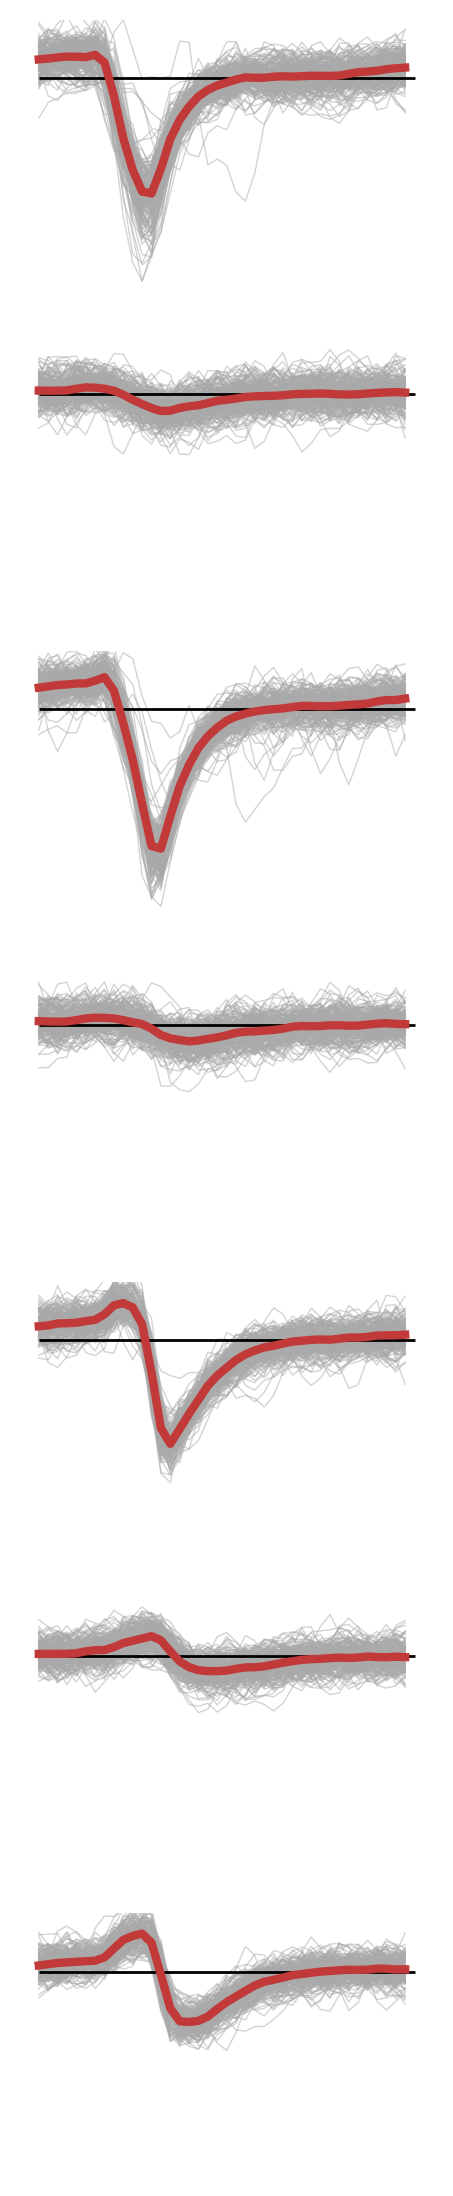

In [168]:
plt.figure(figsize=(8/3, 14))

ylim = [-350,100]
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(spikes[6][:,i,:].T, c='#A9A9A9',  lw=0.5, alpha=0.5
)   
    plt.hlines(0, 0, 40, color="black", lw=1)
    plt.plot(spikes[6][:,i,:].mean(axis=0), c="#C13938", lw=3)
    plt.ylim(ylim)
    plt.axis("off")

# plt.tight_layout()
plt.savefig("../../results/figures/suppfig1_cl6_mean.svg", transparent=True, dpi=300)

In [156]:
acg = {}
for i in [3, 6]:
    acg[i] = slay.auto_correlogram(
        times_multi[i]/30000,
        window_size=0.05,
        bin_width=0.001,
        overlap_tol=5/30000
    )

ccg = slay.x_correlogram(
    times_multi[3]/30000,
    times_multi[6]/30000,
    window_size=0.05,
    bin_width=0.001,
    overlap_tol=5/30000
)

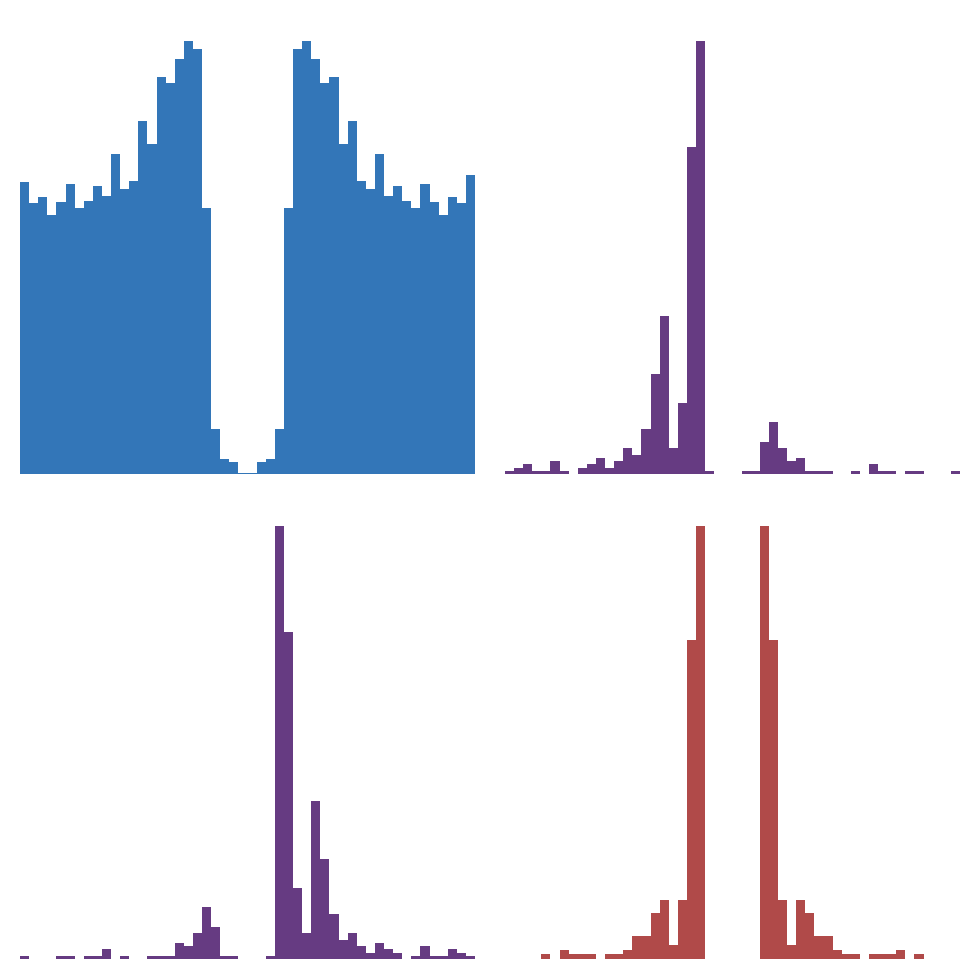

In [160]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
sns.barplot(x=np.arange(len(acg[3])), y=acg[3], color="#1D76CE", width=1);
plt.axis("off")

plt.subplot(2, 2, 2)
sns.barplot(x=np.arange(len(ccg)), y=ccg[::-1], color="#682f8e", width=1);
plt.axis("off")

plt.subplot(2, 2, 3)
sns.barplot(x=np.arange(len(ccg)), y=ccg, color="#682f8eff", width=1);
plt.axis("off")

plt.subplot(2, 2, 4)
sns.barplot(x=np.arange(len(acg[6])), y=acg[6], color="#C13938", width=1);
plt.axis("off")

plt.tight_layout()
plt.savefig("../../results/figures/suppfig1_acg_ccg.svg", transparent=True, dpi=300)

### null vs uniform dist for ccg significance

In [5]:
xcorr_times = np.load("../results/figures/ccg_unif_vs_shfl/xcorr_times.npy")
shfl_xcorr_times = np.load("../results/figures/ccg_unif_vs_shfl/shfl_xcorr_times.npy")

In [74]:
np.arange(len(xcorr_times))

array([0, 1, 2, 3, 4, 5, 6, 7])

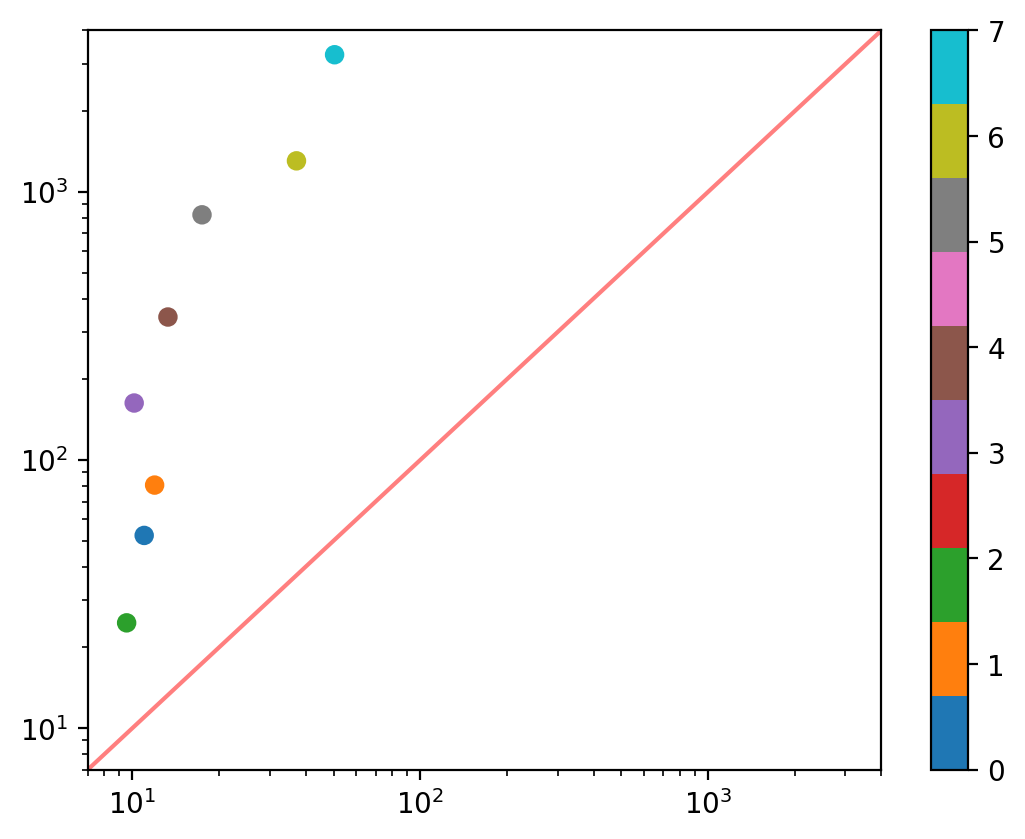

In [75]:
plt.scatter(xcorr_times, shfl_xcorr_times, cmap="tab10", c=np.arange(len(xcorr_times)))
plt.xscale("log")
plt.yscale("log")
plt.xlim(7, 4000)
plt.ylim(7, 4000)
plt.plot(np.arange(7, 4000), np.arange(7, 4000), color="red", alpha=0.5)

plt.savefig("../results/figures/ccg_unif_vs_shfl/runtimes.svg", transparent=True, dpi=300)
plt.colorbar()

In [15]:
pass_ms = np.load("../results/figures/ccg_unif_vs_shfl/pass_ms.npy", allow_pickle=True)
xcorr_sig = np.load("../results/figures/ccg_unif_vs_shfl/xcorr_sig.npy", allow_pickle=True)
shfl_xcorr_sig = np.load("../results/figures/ccg_unif_vs_shfl/shfl_xcorr_sig.npy", allow_pickle=True)

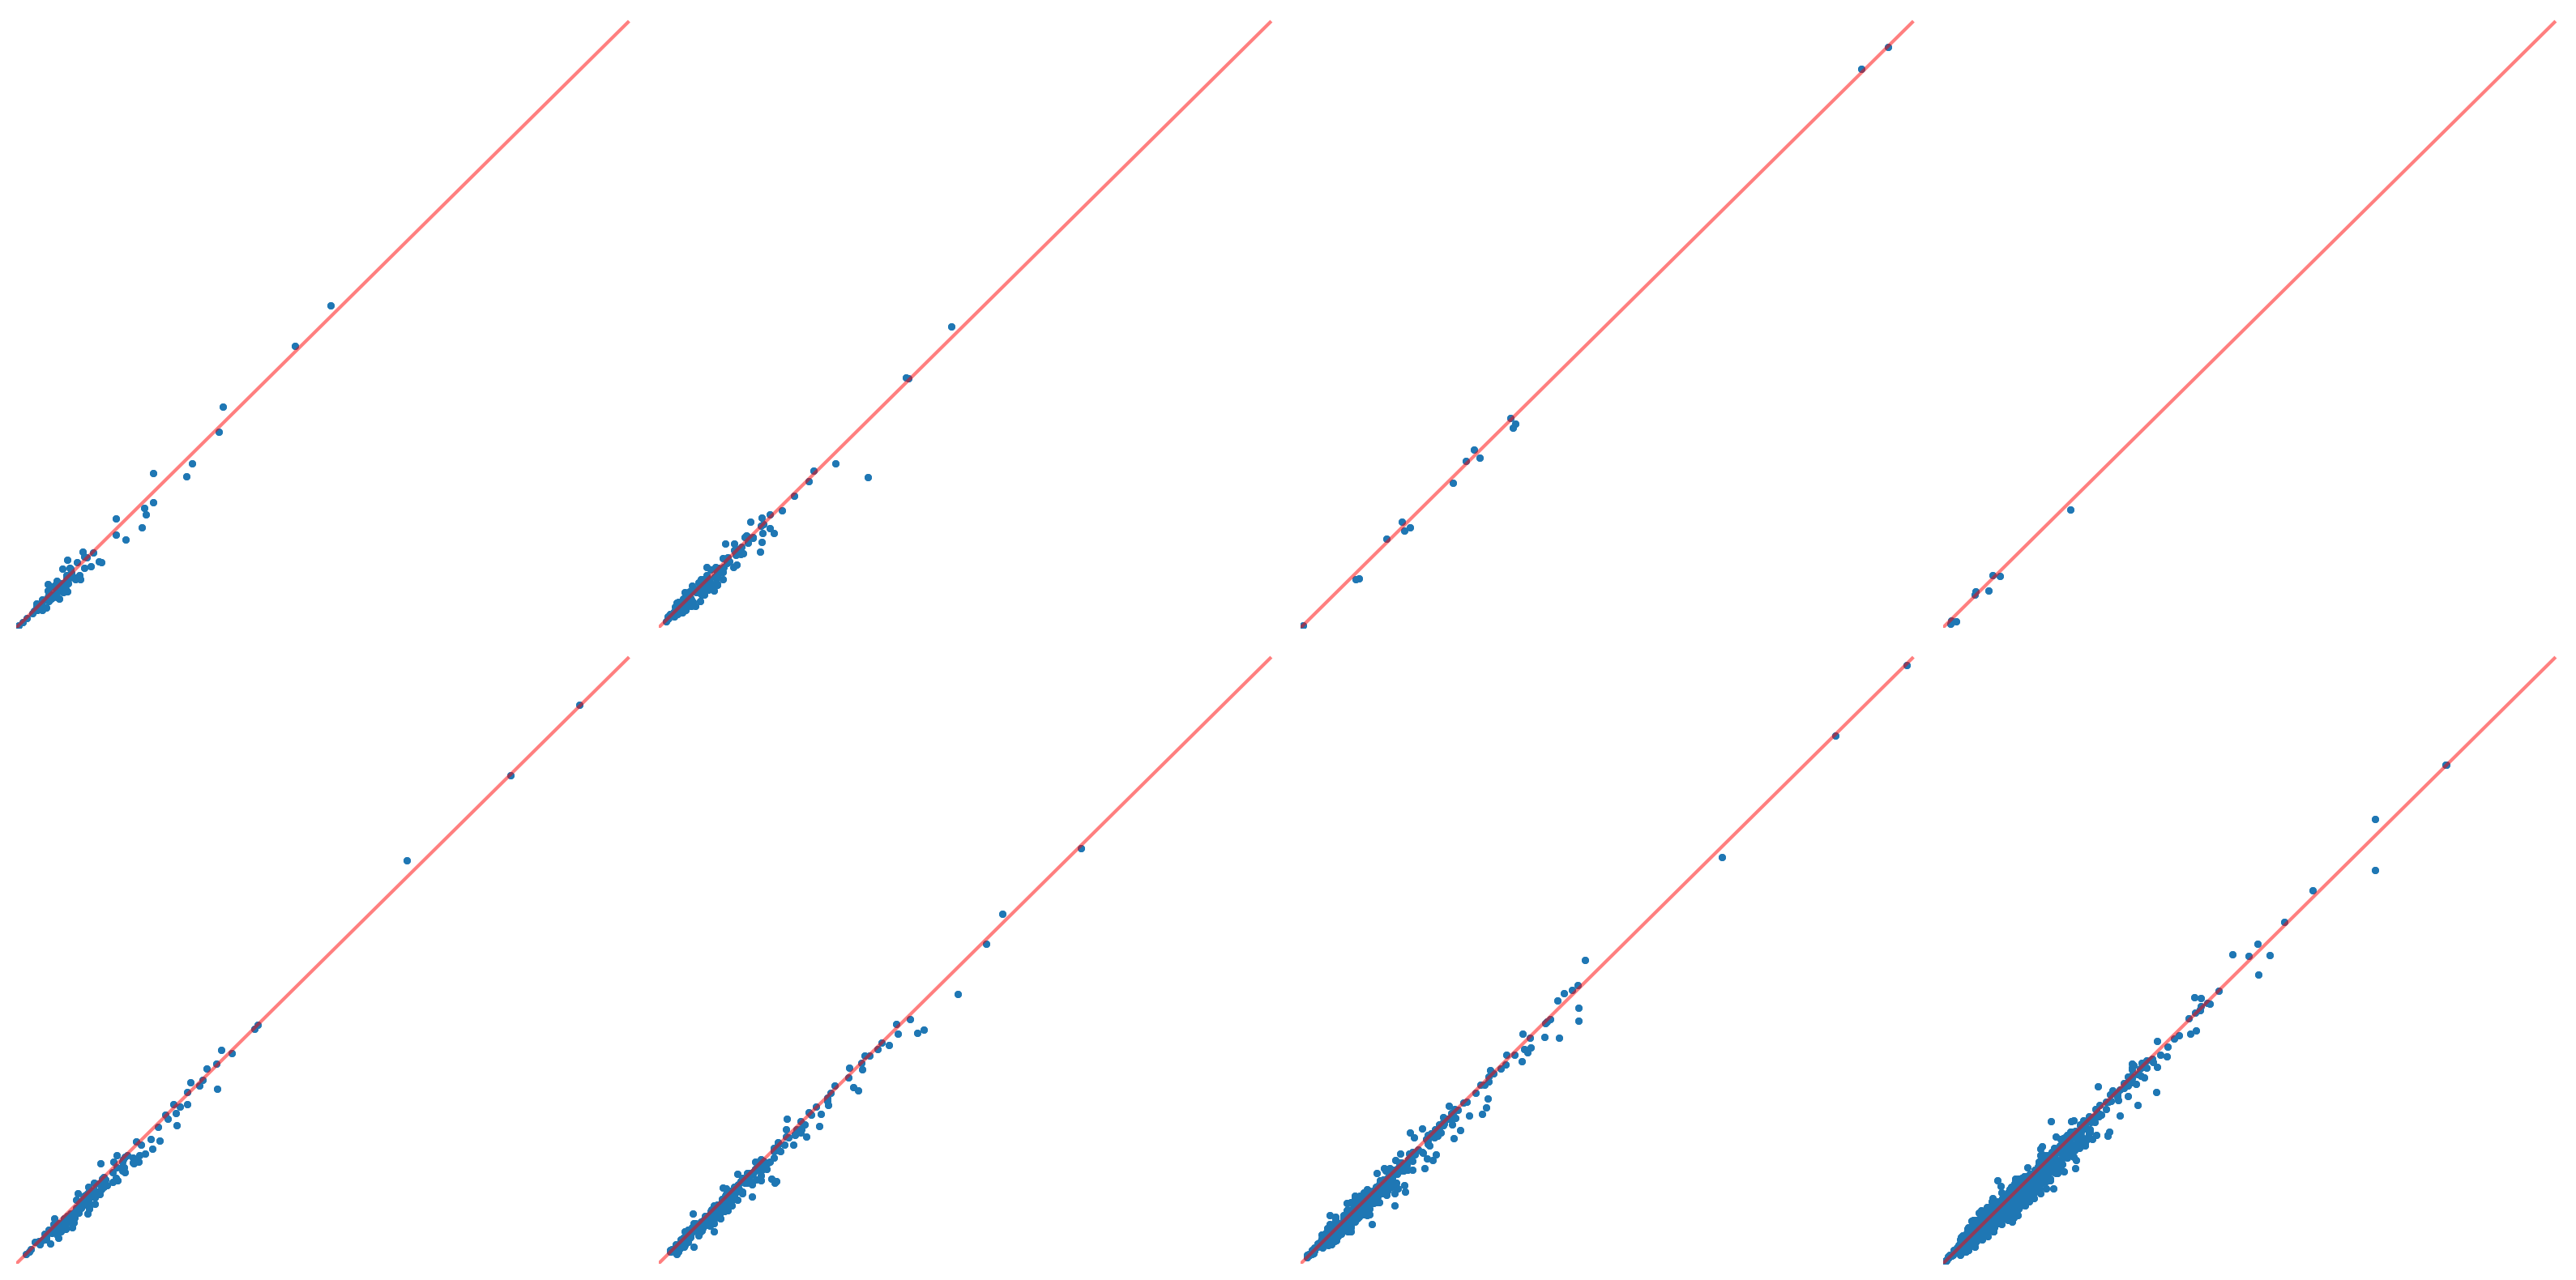

In [ ]:
corrs = np.zeros(8)
meds = np.zeros(8)
mads = np.zeros(8)

plt.figure(figsize=(16, 8))
for i in range(len(pass_ms)):
    xcorr_valid = xcorr_sig[i][pass_ms[i]]
    shfl_xcorr_valid = shfl_xcorr_sig[i][pass_ms[i]]
    plt.subplot(2, 4, i+1)
    plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="red", alpha=0.5)
    plt.scatter(xcorr_valid.flatten(), shfl_xcorr_valid.flatten(), alpha=1, s=5,)
    plt.xlim(0, 1); plt.ylim(0, 1)
    corrs[i] = np.corrcoef(xcorr_valid.flatten(), shfl_xcorr_valid.flatten())[0, 1]
    mads[i] = np.percentile(np.abs(xcorr_valid.flatten()-shfl_xcorr_valid.flatten()), 99)
    meds[i] = np.median(np.abs(xcorr_valid.flatten()-shfl_xcorr_valid.flatten()))
    # plt.hist(xcorr_valid.flatten()-shfl_xcorr_valid.flatten(), bins=100, alpha=0.5, color="blue")
    plt.axis("off")
plt.tight_layout()

plt.savefig("../results/figures/ccg_unif_vs_shfl/ccg_unif_vs_shfl_plots.svg", transparent=True, dpi=300)

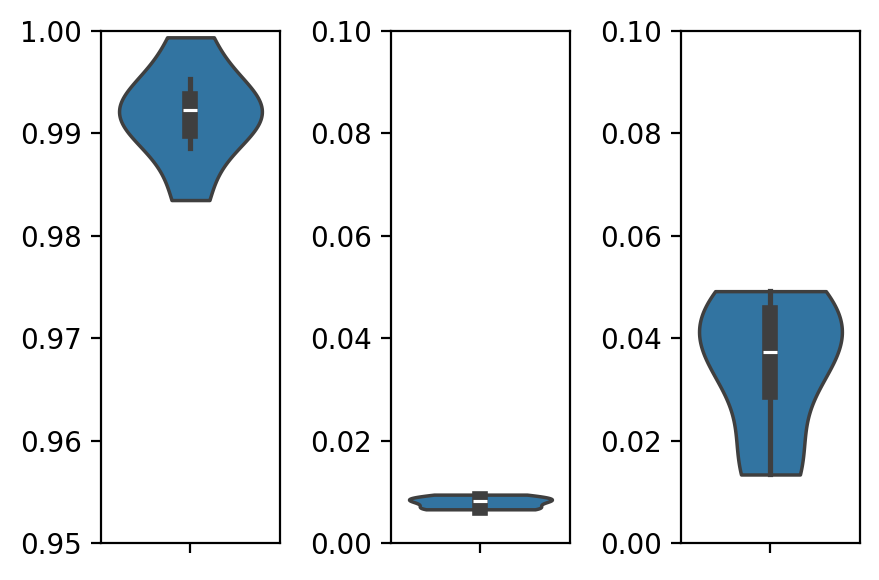

In [73]:
plt.figure(figsize=(4.5, 3))
metrics = np.vstack([corrs, mads])

plt.subplot(1, 3, 1)
sns.violinplot(metrics[0], cut=0)
plt.ylim(0.95, 1)

plt.subplot(1, 3, 3)
sns.violinplot(metrics[1], cut=0)
plt.ylim(0, 0.1)
plt.tight_layout()

plt.subplot(1, 3, 2)
sns.violinplot(meds, cut=0)
plt.ylim(0, 0.1)
plt.tight_layout()

plt.savefig("../results/figures/ccg_unif_vs_shfl/ccg_unif_vs_shfl_metrics.svg", transparent=True, dpi=300)

### AE vs pca dim

In [4]:
def compare_ae_pca(clusters, cl_labels, channel_pos, data, n_clust, times_multi, counts):
    good_ids = np.argwhere(
            (counts > params["min_spikes"]) & (cl_labels["label"].isin(params["good_lbls"]))
        ).flatten()

    mean_wf = slay.calc_mean_wf(
        params,
        n_clust,
        good_ids,
        times_multi,
        data,
    )

    peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf, 2), 1)

    ci = {
    "times_multi": times_multi,
    "counts": counts,
    "good_ids": good_ids,
    "mean_wf": mean_wf,
    }
    ext_params = {
        "pre_samples": params["ae_pre"],
        "post_samples": params["ae_post"],
        "num_chan": params["ae_chan"],
        "for_shft": params["ae_shft"],
    }
    spk_snips, cl_ids = slay.generate_train_data(
        data, ci, channel_pos, ext_params, params
    )

    # Train the autoencoder if needed.
    model_path = (
        params["model_path"]
        if params["model_path"]
        else os.path.join(params["KS_folder"], "automerge", "ae.pt")
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    spk_data = slay.SpikeDataset(spk_snips, cl_ids)
    labels = cl_ids

    train_indices, test_indices = train_test_split(
        np.arange(len(spk_data)), stratify=labels, test_size=0.2, random_state=42
    )
    sample_weights = [
        1 / max(counts[int(label)], 500) for label in labels[test_indices]
    ]
    dims = [3,4,5,10,15,20]
    test_sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(test_indices), replacement=True
    )
    test_split = Subset(spk_data, test_indices)
    test_loader = DataLoader(test_split, batch_size=128, sampler=test_sampler)

    test_snips = torch.zeros((len(test_indices), 320)).to(device)
    for i, (data, _, _) in enumerate(test_loader):
        test_snips[i*128:(i+1)*128] = data.squeeze().reshape(-1, 320)

    #  Run PCA on the snippets
    spk_snips_cpu = spk_snips[train_indices].squeeze().cpu().numpy().reshape(spk_snips[train_indices].shape[0], -1)
    test_snips_cpu = test_snips.cpu().numpy().reshape(test_snips.shape[0], -1)
    pca_loss = np.zeros(len(dims))

    for dim in dims:
        pca = PCA(n_components=dim)
        pca.fit(spk_snips_cpu)

        test_hat = pca.inverse_transform(pca.transform(test_snips_cpu))

        # pca_loss[dims.index(dim)] = calc_exp_var(test_snips, torch.Tensor(test_hat).to(device))[0]

        train_mean = spk_snips_cpu.reshape(train_indices.shape[0], 320).mean(axis=0)
        var_exp = 1 - np.var(test_snips_cpu.reshape(test_indices.shape[0], 320) - test_hat, axis=0)/np.var(test_snips_cpu.reshape(test_indices.shape[0], 320) - train_mean, axis=0)
        pca_loss[dims.index(dim)] = var_exp.mean()

    ae_loss = np.zeros(len(dims))
    for dim in dims:
        print(dim)
        net, spk_data, test_indices = slay.train_ae(spk_snips, cl_ids, counts, num_epochs=25, zDim=dim, return_inds=True, verbose=False)
        
        out, _ = net(spk_snips[test_indices])
        train_mean = spk_snips[train_indices].reshape(train_indices.shape[0], 320).mean(dim=0)
        var_exp = 1 - torch.var(spk_snips[test_indices].reshape(test_indices.shape[0], 320) - out.reshape(test_indices.shape[0], 320), axis=0)/torch.var(spk_snips[test_indices].reshape(test_indices.shape[0], 320) - train_mean, axis=0)
        # loss = torch.nn.functional.mse_loss(test_hat, spk_snips[test_inds].reshape(test_inds.shape[0], 320))
        ae_loss[dims.index(dim)] = var_exp.mean()

        torch.cuda.empty_cache()

    return ae_loss, pca_loss

In [5]:
data_dir = "D:/SLAY_data/"
ae_vars_exp = np.zeros((8, 6))
pca_vars_exp = np.zeros((8, 6))
ind = 0

for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        if ("ks" in dir_name) and ("orig" not in dir_name):
            ks_dir = os.path.join(root, dir_name)
            args = {"KS_folder": ks_dir}
            args = slay.parse_kilosort_params(args)
            schema = RunParams()
            params = schema.load(args)
            clusters, cl_labels, channel_pos, data, n_clust, times_multi, counts = (
                slay.load_ks_files(params)
            )
            ae_vars_exp[ind], pca_vars_exp[ind] = compare_ae_pca(
                clusters, cl_labels, channel_pos, data, n_clust, times_multi, counts
            )
            ind += 1


           

D:\SLAY_data\bijan_monkey_motor\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\rec_bank0_dense_g0_tcat.imec0.ap.bin
Loading files...


Generating snippets: 100%|██████████| 183/183 [00:22<00:00,  8.25it/s]


3


Epoch: 100%|██████████| 25/25 [02:59<00:00,  7.19s/it]


4


Epoch: 100%|██████████| 25/25 [02:56<00:00,  7.08s/it]


5


Epoch: 100%|██████████| 25/25 [03:07<00:00,  7.49s/it]


10


Epoch: 100%|██████████| 25/25 [03:07<00:00,  7.51s/it]


15


Epoch: 100%|██████████| 25/25 [03:04<00:00,  7.36s/it]


20


Epoch: 100%|██████████| 25/25 [03:10<00:00,  7.61s/it]


D:\SLAY_data\bijan_monkey_motor\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\rec_bank0_dense_g0_tcat.imec0.ap.bin
Loading files...


Generating snippets: 100%|██████████| 299/299 [00:46<00:00,  6.43it/s]


3


Epoch: 100%|██████████| 25/25 [05:10<00:00, 12.42s/it]


4


Epoch: 100%|██████████| 25/25 [05:35<00:00, 13.43s/it]


5


Epoch: 100%|██████████| 25/25 [05:39<00:00, 13.59s/it]


10


Epoch: 100%|██████████| 25/25 [05:38<00:00, 13.53s/it]


15


Epoch: 100%|██████████| 25/25 [05:36<00:00, 13.45s/it]


20


Epoch: 100%|██████████| 25/25 [05:41<00:00, 13.65s/it]


D:\SLAy_data\midbrain_cullen\NPX_001_Session_2_preprocessed.bin
Loading files...


Generating snippets: 100%|██████████| 46/46 [00:09<00:00,  4.91it/s]


3


Epoch: 100%|██████████| 25/25 [00:56<00:00,  2.24s/it]


4


Epoch: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


5


Epoch: 100%|██████████| 25/25 [00:55<00:00,  2.24s/it]


10


Epoch: 100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


15


Epoch: 100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


20


Epoch: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


D:\SLAy_data\midbrain_cullen\NPX_001_Session_2_preprocessed.bin
Loading files...


Generating snippets: 100%|██████████| 37/37 [00:08<00:00,  4.53it/s]


3


Epoch: 100%|██████████| 25/25 [00:48<00:00,  1.92s/it]


4


Epoch: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


5


Epoch: 100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


10


Epoch: 100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


15


Epoch: 100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


20


Epoch: 100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


D:\SLAY_data\mouse_hippocampus\catgt_ANM480363_20210527_pfc320_hpc180_g0\ANM480363_20210527_pfc320_hpc180_g0_imec1\ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin
Loading files...


Generating snippets: 100%|██████████| 116/116 [00:31<00:00,  3.63it/s]


3


Epoch: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it]


4


Epoch: 100%|██████████| 25/25 [02:27<00:00,  5.91s/it]


5


Epoch: 100%|██████████| 25/25 [02:25<00:00,  5.83s/it]


10


Epoch: 100%|██████████| 25/25 [02:25<00:00,  5.81s/it]


15


Epoch: 100%|██████████| 25/25 [02:27<00:00,  5.89s/it]


20


Epoch: 100%|██████████| 25/25 [02:26<00:00,  5.86s/it]


D:\SLAY_data\mouse_hippocampus\catgt_ANM480363_20210527_pfc320_hpc180_g0\ANM480363_20210527_pfc320_hpc180_g0_imec1\ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin
Loading files...


Generating snippets: 100%|██████████| 196/196 [00:51<00:00,  3.79it/s]


3


Epoch: 100%|██████████| 25/25 [04:07<00:00,  9.88s/it]


4


Epoch: 100%|██████████| 25/25 [04:07<00:00,  9.89s/it]


5


Epoch: 100%|██████████| 25/25 [04:07<00:00,  9.91s/it]


10


Epoch: 100%|██████████| 25/25 [04:12<00:00, 10.11s/it]


15


Epoch: 100%|██████████| 25/25 [04:08<00:00,  9.96s/it]


20


Epoch: 100%|██████████| 25/25 [04:04<00:00,  9.78s/it]


D:\SLAY_data\rat_insula\catgt_100623_INS6_DT3_rec_g0\100623_INS6_DT3_rec_g0_imec0\100623_INS6_DT3_rec_g0_tcat.imec0.ap.bin
Loading files...


Generating snippets: 100%|██████████| 406/406 [01:44<00:00,  3.90it/s]


3


Epoch: 100%|██████████| 25/25 [08:29<00:00, 20.40s/it]


4


Epoch: 100%|██████████| 25/25 [08:33<00:00, 20.54s/it]


5


Epoch: 100%|██████████| 25/25 [08:32<00:00, 20.51s/it]


10


Epoch: 100%|██████████| 25/25 [08:36<00:00, 20.64s/it]


15


Epoch: 100%|██████████| 25/25 [08:43<00:00, 20.92s/it]


20


Epoch: 100%|██████████| 25/25 [08:35<00:00, 20.61s/it]


D:\SLAY_data\rat_insula\catgt_100623_INS6_DT3_rec_g0\100623_INS6_DT3_rec_g0_imec0\100623_INS6_DT3_rec_g0_tcat.imec0.ap.bin
Loading files...


Generating snippets: 100%|██████████| 649/649 [02:38<00:00,  4.09it/s]


3


Epoch: 100%|██████████| 25/25 [13:32<00:00, 32.52s/it]


4


Epoch: 100%|██████████| 25/25 [13:36<00:00, 32.67s/it]


5


Epoch: 100%|██████████| 25/25 [13:44<00:00, 32.99s/it]


10


Epoch: 100%|██████████| 25/25 [13:40<00:00, 32.83s/it]


15


Epoch: 100%|██████████| 25/25 [13:40<00:00, 32.84s/it]


20


Epoch: 100%|██████████| 25/25 [13:33<00:00, 32.55s/it]


In [6]:
np.save("../results/figures/ae_vars_exp.npy", ae_vars_exp)
np.save("../results/figures/pca_vars_exp.npy", pca_vars_exp)

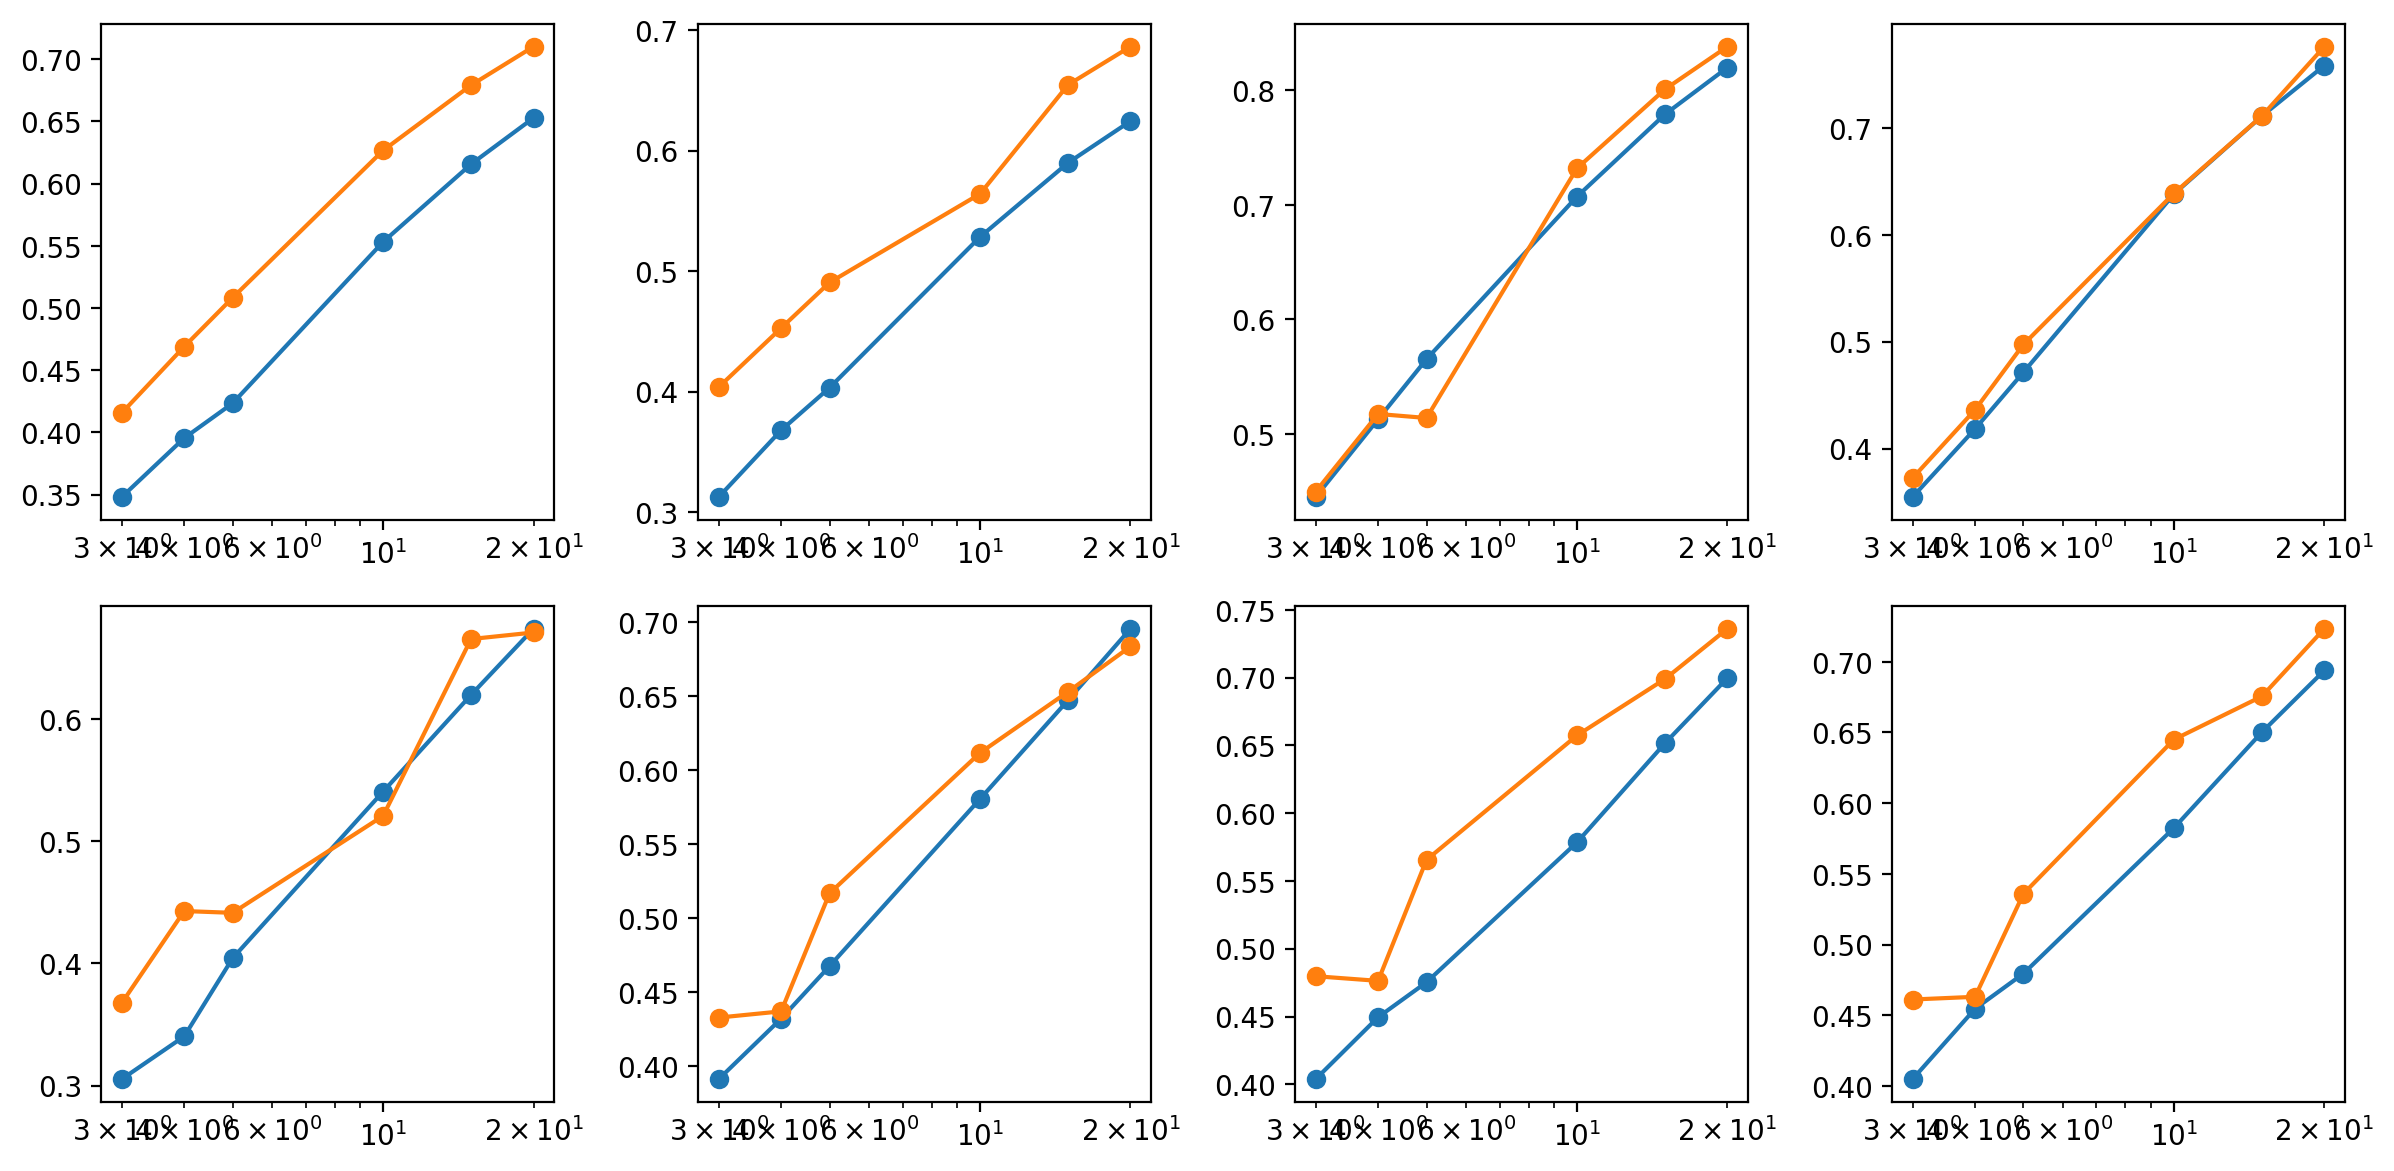

In [7]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot([3,4,5,10,15,20], pca_vars_exp[i], marker='o')
    plt.plot([3,4,5,10,15,20], ae_vars_exp[i], marker='o')
    plt.xscale("log")

plt.tight_layout()